In [11]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex, PositiveReals, Circle

# Utils
from utils.data_utils import load_cmsopendata, load_dataset, calculate_masses, normalize_events, add_pileup
from utils.plot_utils import plot_event
from ot.lp import emd2

# Jets
from pyjet import cluster



# GPU nonsense
import torch 
import torch.nn as nn

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

# Must be imported *after* device
from src.CommonObservables import buildCommmonObservables



Using CPU!


# Data

(100, 200, 3)
(100, 200, 3)
652.7005


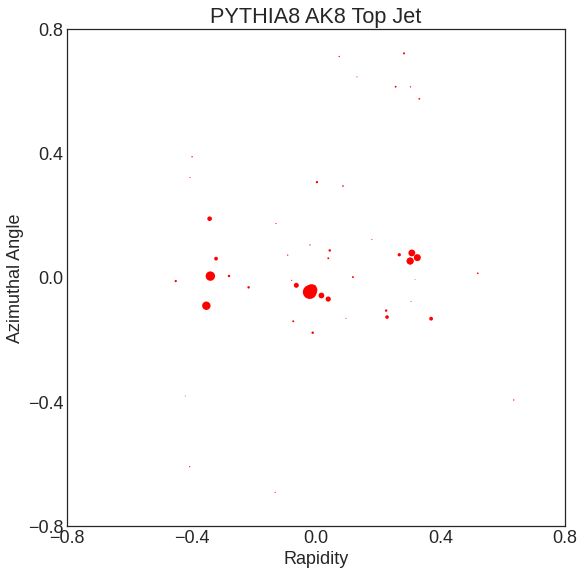

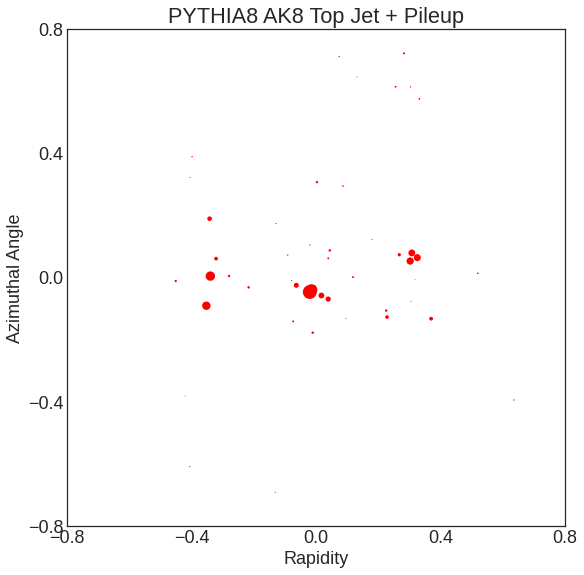

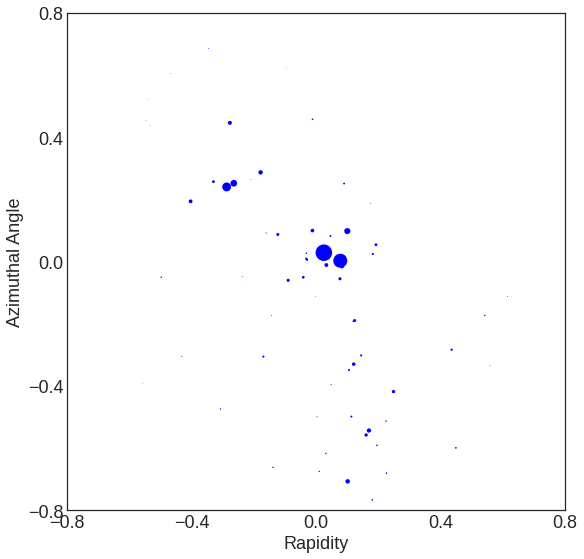

171.30367692878374 0.0
171.30358934257254 0.0


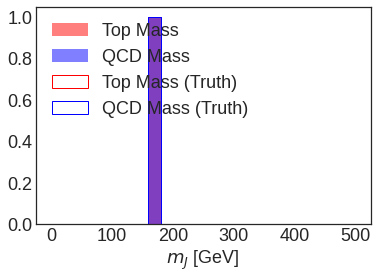

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-5.00087586e-01, -4.00087586e-01, -3.00087586e-01, -2.00087586e-01,
        -1.00087586e-01, -8.75862112e-05,  9.99124138e-02,  1.99912414e-01,
         2.99912414e-01,  3.99912414e-01,  4.99912414e-01]),
 <BarContainer object of 10 artists>)

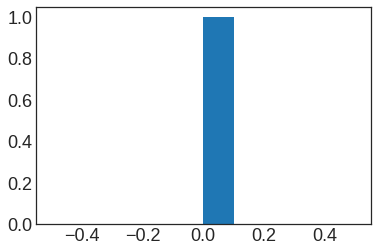

In [12]:
# Parameters
R = 0.8
beta = 1
N = 3
batch_size = 25

mass_lower = 145
mass_upper = 205
pileup = False

pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"


# Load events
signal = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
background = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
signal_mass = calculate_masses(signal)
background_mass = calculate_masses(background)


# Add pileup
if pileup:
    signal_pu, signal_norms = normalize_events(add_pileup(signal, 100, 75, 125, .25, R), return_norm= True)
    background_pu, background_norms = normalize_events(add_pileup(background, 100, 150, 200, .25, R), return_norm= True)
else:
    signal_pu, signal_norms = normalize_events(signal, return_norm= True)
    background_pu, background_norms = normalize_events(background, return_norm= True)


signal_pu_mass = signal_norms * calculate_masses(signal_pu)
background_pu_mass = background_norms * calculate_masses(background_pu)



events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]




# Example plots
example_signal = signal[0]
example_signal_pu = signal_pu[0]
print(example_signal[1].sum())
plot_event(example_signal[0], example_signal[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet", filename= "Plots/top.pdf")
plot_event(example_signal_pu[0], example_signal_pu[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet + Pileup", filename = "Plots/top_pileup.pdf")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

print(np.mean(signal_mass), np.std(signal_mass))
print(np.mean(signal_pu_mass), np.std(signal_pu_mass))


plt.hist(signal_pu_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(background_pu_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(signal_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass (Truth)", alpha = 1.0, histtype="step")
plt.hist(background_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass (Truth)", alpha = 1.0, histtype="step")
plt.legend(loc = "upper left")
plt.xlabel(r"$m_J$ [GeV]")
plt.show()


plt.hist(signal_pu_mass - signal_mass)

In [13]:
from matplotlib.collections import PathCollection
from matplotlib.patches import Rectangle as pltRectangle
from matplotlib.patches import Ellipse as pltEllipse
from matplotlib.patches import Circle as pltCircle

commonObservables, obsarray = buildCommmonObservables(3, 1, R, device)
# _3subjettiness = commonObservables["3-Subjettiness"]
# _3ellipsiness = commonObservables["3-Ellipsiness"]
# _3pointellipsiness = commonObservables["3-Point-Ellipsiness"]

# # Sample from a normalized uniform distribution
# def uniform_sampler(N, param_dict):
#     points = torch.FloatTensor(N, 2).uniform_(-R, R).to(device)

#     zs = torch.ones((N,)).to(device) / N
#     return (points, zs)

# _isotropy = Observable({}, uniform_sampler, beta = 1, R = 0.8)



# def temp_plotter(ax, param_dict):

#     centers = param_dict["Points"].params.clone().detach().numpy()
#     radii1 = param_dict["Radius1"].params.clone().detach().numpy()
#     radii2 = param_dict["Radius2"].params.clone().detach().numpy()
#     angles = param_dict["Angles"].params.clone().detach().numpy()
#     weights = param_dict["Weights"].params.clone().detach().numpy() * param_dict["Joint Weights"].params.clone().detach().numpy()[0]
#     num = param_dict["Points"].N
#     pileup = param_dict["Joint Weights"].params.clone().detach().numpy()[1]

#     # points, zs = point_ellipse_sampler(100, param_dict)
#     # points = points.clone().detach().numpy()

#     # ax.scatter(points[:,0], points[:,1], color = "Purple",  marker = "o", alpha = 0.1)


#     for i in range(num):
#         # Circle
#         draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "purple", edgecolor = "purple", alpha = 1.0 * weights[i+num], zorder = 12)
#         ax.add_artist(draw_circle)

#         draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "none", edgecolor = "purple", alpha = 0.75)
#         ax.add_artist(draw_circle)

#         # Center
#         ax.scatter(centers[i,0], centers[i,1], color = "Purple",  marker = "x", s = 2 * weights[i] * 500/np.sum(weights), alpha = 0.75, zorder = 15, lw = 3)
        
#         # Text
#         eccentricity = np.sqrt(1 - min(radii1[i], radii2[i]) / max(radii1[i], radii2[i]))
#         if num > 1:
#             s = "%d) " % (num - i)
#         else:
#             s = ""
#         # plt.text(0.05, 0.15 + 0.10*i, s + r"x: (%.2f, %.2f), z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f)" % (centers[i,0], centers[i,1], weights[i], weights[i+num], ), fontsize = 18, transform = plt.gca().transAxes)
#         # plt.text(0.05, 0.10 + 0.10*i, r"    Eff. Rad: %.2f, Ecc: %.2f" % (np.sqrt(radii1[i] * radii2[i]), eccentricity), fontsize = 18, transform = plt.gca().transAxes)

#         plt.text(0.05, 0.10 + 0.05*i, s + r"Eff. Rad: %.2f, Ecc: %.2f, z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f)" % (np.sqrt(radii1[i] * radii2[i]), eccentricity, weights[i], weights[i+num], ), fontsize = 18, transform = plt.gca().transAxes)


#     plt.text(0.05, 0.10 + 0.05*num, r"z$_{PU}$: %.2f" % (pileup), fontsize = 18, transform = plt.gca().transAxes)
#     draw_rect = pltRectangle( (-R*0.9, -R*0.9), 2*R*0.9, 2*R*0.9, angle = 0, facecolor = "purple", edgecolor = "purple", alpha = 0.50 * pileup)
#     ax.add_artist(draw_rect)    

    


# def temp_plotter_2(ax, param_dict):

#     centers = param_dict["Points"].params.clone().detach().numpy()
#     radii1 = param_dict["Radius1"].params.clone().detach().numpy()
#     radii2 = param_dict["Radius2"].params.clone().detach().numpy()
#     angles = param_dict["Angles"].params.clone().detach().numpy()
#     weights = param_dict["Weights"].params.clone().detach().numpy() * param_dict["Joint Weights"].params.clone().detach().numpy()[0]
#     num = param_dict["Points"].N
#     pileup = param_dict["Joint Weights"].params.clone().detach().numpy()[1]

#     for i in range(num):
        
#         # Circle
#         draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "purple", edgecolor = "purple", alpha = 1.0 * weights[i], zorder = 12)
#         ax.add_artist(draw_circle)

#         draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "none", edgecolor = "purple", alpha = 0.75)
#         ax.add_artist(draw_circle)

      
#         # Text
#         eccentricity = np.sqrt(1 - min(radii1[i], radii2[i]) / max(radii1[i], radii2[i]))
#         if num > 1:
#             s = "%d) " % (num - i)
#         else:
#             s = ""
#         # plt.text(0.05, 0.15 + 0.10*i, s + r"x: (%.2f, %.2f), z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f)" % (centers[i,0], centers[i,1], weights[i], weights[i+num], ), fontsize = 18, transform = plt.gca().transAxes)
#         # plt.text(0.05, 0.10 + 0.10*i, r"    Eff. Rad: %.2f, Ecc: %.2f" % (np.sqrt(radii1[i] * radii2[i]), eccentricity), fontsize = 18, transform = plt.gca().transAxes)

#         plt.text(0.05, 0.10 + 0.05*i, s + r"Eff. Rad: %.2f, Ecc: %.2f, z$_\mathcal{O}$: %.2f" % (np.sqrt(radii1[i] * radii2[i]), eccentricity, weights[i], ), fontsize = 18, transform = plt.gca().transAxes)


#     plt.text(0.05, 0.10 + 0.05*num, r"z$_{PU}$: %.2f" % (pileup), fontsize = 18, transform = plt.gca().transAxes)
#     draw_rect = pltRectangle( (-R*0.9, -R*0.9), 2*R*0.9, 2*R*0.9, angle = 0, facecolor = "purple", edgecolor = "purple", alpha = 0.50 * pileup)
#     ax.add_artist(draw_rect)    



# observables_array = []
# observables = {}

# observables["3-Subjettiness"] = _3subjettiness

# # 3 Points + Ellipse + Pileup
# _temp_observable = _3pointellipsiness + _isotropy
# _temp_observable.params["Joint Weights"].default_value = torch.tensor([1.0,0.00])
# _temp_observable.plotter = temp_plotter
# observables["3-Point-Ellipsiness-Plus-Pileup"] = _temp_observable


# # 3 Ellipse + Pileup
# _temp_observable_2 = _3ellipsiness + _isotropy
# _temp_observable_2.params["Joint Weights"].default_value = torch.tensor([1.0,0.00])
# _temp_observable_2.plotter = temp_plotter_2
# observables["3-Ellipsiness-Plus-Pileup"] = _temp_observable_2

shaper = Shaper(commonObservables, device)
shaper.to(device)


batches = int(N / batch_size) + 1

plot_dictionary_signal = {
    "plot_directory" : "Plots/Test",
    "gif_directory" : "Plots/Signal/gifs",  
    "extension" : "png",
    "title" : "PYTHIA8 Top Jets"
}

plot_dictionary_background = {
    "plot_directory" : "Plots/Background",
    "gif_directory" : "Plots/Background/gifs",  
    "extension" : "png",
    "title" : "PYTHIA8 QCD Jets"
}


for batch in range(batches):

    print("BATCH: %d" % batch)
    start = batch * batch_size
    end = (batch + 1) * batch_size

    cms_emds, cms_params = shaper.calculate(signal_pu[start:end], epochs = 150, verbose=True, lr = 0.01, N = 150, scaling = 0.9, epsilon = 0.001, early_stopping= 150, plot_dictionary=plot_dictionary_signal)
    # cms_emds, cms_params = shaper.calculate(background_pu[start:end], epochs = 500, verbose=True, lr = 0.01, N = 150, scaling = 0.9, epsilon = 0.001, early_stopping= 100, plot_dictionary=plot_dictionary_background)

    # np.save('data/batch_params_test_%d.npy' % batch, cms_params)


BATCH: 0
[0.99323487 0.        ]
[0.99323487 0.        ]
[0.72147232 0.2725954  0.         0.        ]
[0.72147232 0.2725954  0.         0.        ]
[0.49210372 0.2725954  0.22949116 0.         0.         0.        ]
[0.49210372 0.2725954  0.22949116 0.         0.         0.        ]
Observable: 1-Subjettiness Epoch 0 Mean Loss = 0.2563500702381134 Elapsed time = 1.013s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 1 Mean Loss = 0.25126180052757263 Elapsed time = 1.056s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 2 Mean Loss = 0.2473364770412445 Elapsed time = 1.093s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 3 Mean Loss = 0.24354657530784607 Elapsed time = 1.127s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 4 Mean Loss = 0.24025097489356995 Elapsed time = 1.161s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 5 Mean Loss = 0.2419167160987854 Elapsed time = 1.195s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 6

In [14]:
param_dict = cms_params["3-Point-Ellipsiness-Plus-Pileup"][0]
print(param_dict)

param_dict = {"Points" : np.array(((0.0, 0.0),)),
              "Radius1" : np.array((0.5,)),
              "Radius2" : np.array((1.5,)),
              "Angles" : np.array((15.0,)),
              "Weights" : np.array((0.5, 0.5))
              }


# Point plus disk
def point_ellipse_sampler(N, param_dict):

    centers = param_dict["Points"]
    num = param_dict["Points"].shape[0]
    radii1 = param_dict["Radius1"]
    radii2 = param_dict["Radius2"]
    angles = param_dict["Angles"]
    weights = param_dict["Weights"]
    phi = 2 * np.pi * np.random.rand(num, N)
    r =  np.sqrt(np.random.rand(num, N))

    x0 = radii1[:,None] * np.cos(phi)
    y0 = radii2[:,None] * np.sin(phi)

    x = x0*np.cos(angles[:,None]) - y0*np.sin(angles[:,None])
    y = x0*np.sin(angles[:,None]) + y0*np.cos(angles[:,None])
    points = np.stack([x, y], axis = 1)   * r[:,None,:] + centers[:,:,None]

    points = np.concatenate([point for point in points], axis = 1)
    plt.scatter(points[0], points[1])
    print(points.shape)

    # Concatenate and reweight
    e = np.concatenate([centers, points.T], axis = 0)
    z1 = np.concatenate([weights[i] * np.ones((1,)) for i in range(num)], axis = 0)
    z2 = np.concatenate([weights[num + i] * np.ones((N,)) / N for i in range(num)], axis = 0)
    z = np.concatenate([z1, z2], axis = 0)
    print(e.shape)
    plt.scatter(e[:,0], e[:,1])
    return (e, z)

def point_ellipse_plotter(ax, param_dict):

    centers = param_dict["Points"]
    radii1 = param_dict["Radius1"]
    radii2 = param_dict["Radius2"]
    angles = param_dict["Angles"]
    weights = param_dict["Weights"]
    num = param_dict["Points"].shape[0]


    points, zs = point_ellipse_sampler(100, param_dict)
    # points = points.clone().detach().numpy()

    ax.scatter(points[:,0], points[:,1], color = "Purple",  marker = "o", alpha = 0.1)

    for i in range(num):
        # Circle
        draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "purple", edgecolor = "purple", alpha = 0.25)
        ax.add_artist(draw_circle)


        # Center
        ax.scatter(centers[i,0], centers[i,1], color = "Purple",  marker = "x", s = 2 * weights[i] * 500/np.sum(weights), alpha = 0.5)
        
        # Text
        eccentricity = np.sqrt(1 - min(radii1[i], radii2[i]) / max(radii1[i], radii2[i]))
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""
        plt.text(0.05, 0.15 + 0.10*i, s + r"x: (%.2f, %.2f), z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f)" % (centers[i,0], centers[i,1], weights[i], weights[i+num], ), fontsize = 18, transform = plt.gca().transAxes)
        plt.text(0.05, 0.10 + 0.10*i, r"    Eff. Rad: %.2f, Ecc: %.2f" % (np.sqrt(radii1[i] * radii2[i]), eccentricity), fontsize = 18, transform = plt.gca().transAxes)






fig, ax = plt.subplots(figsize = (8,8))
ax.axis("equal")
point_ellipse_plotter(ax, param_dict)
plt.grid()
plt.show()




KeyError: '3-Point-Ellipsiness-Plus-Pileup'

In [ ]:
def load_params_from_batches(set, batches):

    # Initialize
    params = {}
    for obs in observables:
        params[obs] = []

    # Loop over batches
    for batch in range(batches):
        pa = np.load('data/%s_params_%d.npy' % (set, batch), allow_pickle = True)[()]
        for obs in observables:
            for i in range(len(pa[obs])):
                params[obs].append(pa[obs][i])

    return params
signal_params = load_params_from_batches("signal", 5)
background_params = load_params_from_batches("background", 5)
print(signal_params["3-Subjettiness"][0])

In [ ]:
from sklearn.metrics import roc_curve, auc
from matplotlib.patches import Patch

def plot_observable_param(obs, param, xlim, function = None, xlabel = None, complex_function = None):

    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

    bins = 25
    sg = []
    bg = []


    for i in range(5000):

        if complex_function is not None:
            sg.append(complex_function(signal_params, obs, i))
            bg.append(complex_function(background_params, obs, i))            

        elif function is None:

            sg.append(signal_params[obs][i][param])
            bg.append(background_params[obs][i][param])

        else:

            sg.append(function(signal_params[obs][i]))
            bg.append(function(background_params[obs][i]))            


            


    sg = np.array(sg)
    bg = np.array(bg)


    # Calculate ROC
    labels = np.concatenate((np.zeros((sg.shape[0],)), np.ones((bg.shape[0],))))
    y_= np.concatenate((sg, bg))

    fpr, tpr, _ = roc_curve(labels, y_)
    roc_auc = auc(fpr, tpr)
    roc_auc = max(roc_auc, 1 - roc_auc)


    b_counts, b_bins, _ = plt.hist(bg, bins = bins, range = xlim, density = True, lw = 3, color = "blue", histtype="step", label = "QCD Jets")
    s_counts, s_bins, _ =plt.hist(sg, bins = bins, range = xlim, density = True, lw = 3, color = "red", histtype="step", label = "Top Jets")

    # for style, fill in hists
    plt.hist(bg, bins = bins, range = xlim, density = True, lw = 3, color = "blue", histtype="stepfilled", alpha = 0.1)
    plt.hist(sg, bins = bins, range = xlim, density = True, lw = 3, color = "red", histtype="stepfilled", alpha = 0.1)


    # Cosmetics
    legend_elements = [Patch(facecolor= (0,0,1,0.1), edgecolor='b', lw = 2, label='QCD Jets'),
                       Patch(facecolor= (1,0,0,0.1), edgecolor='r', lw = 2, label='Top Jets')]




    plt.legend(handles = legend_elements, frameon = False, title = "AUC = %.3f" % roc_auc)

    b_max = max(b_counts)
    s_max = max(s_counts)
    y_lim = max(b_max, s_max) * 1.25
    plt.ylim(0, y_lim)

    plt.text(0.1, 0.925, r'145 GeV < $m_J$ < 205 GeV',  verticalalignment='center', transform=ax.transAxes)
    plt.text(0.1, 0.875, r'475 GeV < $p_T$ < 525 GeV',  verticalalignment='center', transform=ax.transAxes)


    plt.xlabel(param)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.title("%s: %s, PYTHIA8" % (obs, param), loc = "right")

    plt.savefig("Plots/Parameters/parameters_%s_%s.pdf" % (obs, param))
    plt.show()
    plt.close()


In [ ]:
def effective_radius(param_dict):
    a = param_dict["Radius1"][0]
    b = param_dict["Radius2"][0]
    return np.sqrt(a * b)

plot_observable_param("1-Ringiness", "Radius", [0,0.8])
plot_observable_param("1-Point-Ringiness", "Radius", [0,0.8])

plot_observable_param("1-Diskiness", "Radius", [0,0.8])
plot_observable_param("1-Point-Diskiness", "Radius", [0,0.8])

plot_observable_param("1-Ellipsiness", "Radius", [0,0.8], effective_radius, xlabel= r"Effective Radius = $\sqrt{ab}$")
plot_observable_param("1-Point-Ellipsiness", "Radius", [0,0.8], effective_radius, xlabel= r"Effective Radius = $\sqrt{ab}$")

def min_eccentricity(param_dict):
    a = param_dict["Radius1"]
    b = param_dict["Radius2"]
    e = np.sqrt(1 - np.nan_to_num(np.minimum(a, b) / np.maximum(a,b)))
    return np.amin(e)

def max_eccentricity(param_dict):
    a = param_dict["Radius1"]
    b = param_dict["Radius2"]
    e = np.sqrt(1 - np.nan_to_num(np.minimum(a, b) / np.maximum(a,b)))
    return np.amin(e)

plot_observable_param("1-Ellipsiness", "Eccentricity", [0,1.0], min_eccentricity, xlabel = "Minimum Eccentricity")
plot_observable_param("1-Point-Ellipsiness", "Eccentricity", [0,1.0], min_eccentricity, xlabel = "Minimum Eccentricity")

plot_observable_param("2-Ellipsiness", "Eccentricity", [0,1.0], min_eccentricity, xlabel = "Minimum Eccentricity")
plot_observable_param("2-Point-Ellipsiness", "Eccentricity", [0,1.0], min_eccentricity, xlabel = "Minimum Eccentricity")

plot_observable_param("3-Ellipsiness", "Eccentricity", [0,1.0], min_eccentricity, xlabel = "Minimum Eccentricity")
plot_observable_param("3-Point-Ellipsiness", "Eccentricity", [0,1.0], min_eccentricity, xlabel = "Minimum Eccentricity")



plot_observable_param("1-Ellipsiness", "Eccentricity", [0,1.0], max_eccentricity, xlabel = "Maximum Eccentricity")
plot_observable_param("1-Point-Ellipsiness", "Eccentricity", [0,1.0], max_eccentricity, xlabel = "Maximum Eccentricity")

plot_observable_param("2-Ellipsiness", "Eccentricity", [0,1.0], max_eccentricity, xlabel = "Maximum Eccentricity")
plot_observable_param("2-Point-Ellipsiness", "Eccentricity", [0,1.0], max_eccentricity, xlabel = "Maximum Eccentricity")

plot_observable_param("3-Ellipsiness", "Eccentricity", [0,1.0], max_eccentricity, xlabel = "Maximum Eccentricity")
plot_observable_param("3-Point-Ellipsiness", "Eccentricity", [0,1.0], max_eccentricity, xlabel = "Maximum Eccentricity")



def collinear_weights(param_dict):
    z = param_dict["Weights"][0]
    return z


plot_observable_param("1-Point-Ringiness", "Weights", [0,1.0], collinear_weights, xlabel= r"1-Point Weight $z_{\delta}$")
plot_observable_param("1-Point-Diskiness", "Weights", [0,1.0], collinear_weights, xlabel= r"1-Point Weight $z_{\delta}$")
plot_observable_param("1-Point-Ellipsiness", "Weights", [0,1.0], collinear_weights, xlabel= r"1-Point Weight $z_{\delta}$")


# Plot all EMDS:
for obs in observables:
    plot_observable_param(obs, "EMD", [0, 0.350])


# Tau 32, 21
def tau_32(param_dict, obs, i):
    tau = param_dict["3-%s" % obs][i]["EMD"] /  param_dict["2-%s" % obs][i]["EMD"]
    return tau


strings = ["Subjettiness", "Ringiness", "Diskiness", "Ellipsiness", "Point-Ringiness", "Point-Diskiness", "Point-Ellipsiness"]

for s in strings:
    plot_observable_param(s, "tau", [0,1.0], complex_function = tau_32, xlabel= r"3-%s / 2-%s" % (s, s))
# plot_observable_param("1-Point-Diskiness", "Weights", [0,1.0], complex_function = tau_32, xlabel= r"1-Point Weight $z_{\delta}$")
# plot_observable_param("1-Point-Ellipsiness", "Weights", [0,1.0], complex_function = tau_32, xlabel= r"1-Point Weight $z_{\delta}$")



In [ ]:

def hardest_weight(param_dict):
    z = np.amax(param_dict["Weights"][:3])
    return z


def hist_2d(obs, param, xlim, function = None, xlabel = None, complex_function = None):

    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

    bins = 25
    sgx = []
    bgx = []

 

    sgy = []
    bgy = []


    for i in range(250):


        sgx.append(tau_32(signal_params, obs, i))
        bgx.append(tau_32(background_params, obs, i)) 

        sgy.append(hardest_weight(signal_params["3-Point-Ellipsiness"][i])    )
        bgy.append(hardest_weight(background_params["3-Point-Ellipsiness"][i])  ) 

    sgx = np.array(sgx)
    bgx = np.array(bgx)

    sgy = np.array(sgy)
    bgy = np.array(bgy)


    # # Calculate ROC
    # labels = np.concatenate((np.zeros((sg.shape[0],)), np.ones((bg.shape[0],))))
    # y_= np.concatenate((sg, bg))

    # fpr, tpr, _ = roc_curve(labels, y_)
    # roc_auc = auc(fpr, tpr)
    # roc_auc = max(roc_auc, 1 - roc_auc)


    plt.scatter(bgx, bgy, color = "blue", label = "QCD Jets")
    plt.scatter(sgx, sgy, color = "red", label = "Top Jets")


    # Cosmetics
    plt.legend(frameon = False)
    plt.xlabel(param)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.ylabel(r"Hardest Point Weight $z_{\delta}$")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title("%s: PYTHIA8 Top/QCD Jets" % (obs))

    plt.savefig("Plots/Parameters/hist2d_%s_%s.pdf" % (obs, param))
    plt.show()
    plt.close()
    
hist_2d("Point-Ellipsiness", "", [0,1], xlabel= "3-Point-Ellipsiness / 2-Point-Ellipsiness")